### Import Modules

In [9]:
# PyTorch 라이브러리를 임포트합니다.
import torch  # 텐서 연산 및 자동 미분 기능을 제공하는 라이브러리

# PyTorch의 신경망 모듈을 임포트합니다.
import torch.nn as nn  # 신경망 레이어 및 손실 함수를 포함하여 모델을 구축하는 데 사용

# 데이터 시각화를 위한 matplotlib 라이브러리를 임포트합니다.
import matplotlib.pyplot as plt  # 그래프 및 플롯을 그려 데이터 시각화를 지원

# torchvision 라이브러리에서 데이터셋과 변환 기능을 임포트합니다.
from torchvision import datasets, transforms  # 다양한 표준 데이터셋과 이미지 변환 기능 제공

# 데이터셋을 관리하고 로드하기 위한 유틸리티를 임포트합니다.
from torch.utils.data import Dataset, ConcatDataset, DataLoader  # 데이터셋 클래스 생성 및 배치 단위 데이터 로드를 지원

# torchvision에서 사전 훈련된 모델 아키텍처를 임포트합니다.
import torchvision.models as models  # ResNet, VGG 등 다양한 사전 훈련된 모델을 쉽게 사용할 수 있게 해줌

### Load Dataset

In [10]:
# CIFAR-10 데이터셋을 로드하는 함수 정의
def load_CIFAR10(root_dataset, batch_size, width=32, height=32):
    # CIFAR-10 데이터셋의 RGB 채널 평균과 표준편차 정의
    mean = [0.4914, 0.4822, 0.4465]  # 이미지의 평균 색상 값
    std = [0.2023, 0.1994, 0.2010]    # 이미지의 표준편차 값

    # 훈련 데이터에 대한 변환 작업 정의
    image_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # 32x32 크기로 랜덤하게 크롭하고 4픽셀 패딩 추가
        transforms.RandomHorizontalFlip(),      # 50% 확률로 이미지를 수평으로 반전
        transforms.ToTensor(),                  # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize(mean, std),        # 평균과 표준편차로 정규화하여 데이터의 분포를 맞춤
        transforms.RandomErasing(p=0.5)        # 50% 확률로 이미지의 랜덤 부분을 지우는 데이터 증강 기법
    ])

    # 테스트 데이터에 대한 변환 작업 정의
    image_transform_test = transforms.Compose([
        transforms.Resize((width, height)),     # 지정된 크기(width, height)로 이미지 크기 조정
        transforms.ToTensor(),                   # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize(mean, std),         # 평균과 표준편차로 정규화하여 데이터의 분포를 맞춤
    ])

    # CIFAR-10 훈련 데이터셋 다운로드 및 로드
    train_cifar10 = datasets.CIFAR10(root=root_dataset, train=True, download=True, transform=image_transform)
    # CIFAR-10 테스트 데이터셋 다운로드 및 로드
    test_cifar10 = datasets.CIFAR10(root=root_dataset, train=False, download=True, transform=image_transform_test)

    # DataLoader 생성하여 배치 단위로 데이터 로드 설정
    train_cifar10_loader = DataLoader(dataset=train_cifar10, batch_size=batch_size, shuffle=True, num_workers=4)
    test_cifar10_loader = DataLoader(dataset=test_cifar10, batch_size=batch_size, shuffle=False, num_workers=4)

    # CIFAR-10 데이터셋의 클래스 수 반환 (CIFAR-10은 총 10개 클래스)
    nb_classes_cifar10 = len(test_cifar10.classes)

    # 훈련 데이터 로더, 테스트 데이터 로더, 클래스 수를 반환
    return train_cifar10_loader, test_cifar10_loader, nb_classes_cifar10


### Define Model Architecture

In [11]:
# ResNet-50 사전 학습된 모델을 불러오는 함수 정의
def resnet50_pretrained(num_classes):
    # ImageNet 데이터로 사전 학습된 ResNet-50 모델을 로드합니다.
    model = models.resnet50(weights='IMAGENET1K_V1')

    # CIFAR-10 데이터셋의 이미지 크기는 32x32이므로,
    # 첫 번째 합성곱 레이어를 수정하여 입력 이미지 크기에 맞춥니다.
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # ResNet-50의 기본 구조에서 맥스풀링 레이어를 제거합니다.
    # 'nn.Identity()'를 사용해 해당 레이어를 대체하여 기능적으로 아무 변화도 없도록 합니다.
    model.maxpool = nn.Identity()

    # Fully connected 레이어를 수정합니다.
    # 드롭아웃을 추가하여 과적합을 방지하고, 클래스 수에 맞게 출력층을 조정합니다.
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # 드롭아웃 비율을 50%로 설정
        nn.Linear(model.fc.in_features, num_classes)  # 출력층의 입력 특성 수를 CIFAR-10의 클래스 수에 맞게 조정
    )

    # 수정된 모델을 반환합니다.
    return model

### Training Function

In [12]:
# 트레이닝 함수를 정의합니다.
def train(device, model, train_loader, criterion, optimizer):
    model.train()  # 모델을 훈련 모드로 설정하여 드롭아웃과 배치 정규화가 훈련 모드로 작동하도록 함
    train_loss = 0  # 훈련 손실을 초기화하는 변수

    # 배치 단위로 데이터셋을 반복합니다.
    for x, y in train_loader:
        optimizer.zero_grad()  # 이전 배치의 기울기를 초기화하여 누적되지 않도록 함
        x = x.to(device)  # 입력 데이터(x)를 지정된 장치(GPU 또는 CPU)로 이동
        y = y.to(device)  # 레이블(y)을 지정된 장치로 이동

        output = model(x)  # 모델에 입력 데이터를 통과시켜 예측값(output)을 생성
        loss = criterion(output, y)  # 예측값과 실제 레이블을 비교하여 손실(loss) 계산

        loss.backward()  # 손실에 대한 기울기를 계산하여 모델의 가중치에 대한 기울기를 업데이트
        optimizer.step()  # 옵티마이저를 통해 가중치를 업데이트

        train_loss += loss.item()  # 현재 배치의 손실을 누적하여 전체 손실에 더함

    train_loss /= len(train_loader)  # 전체 배치 수로 나누어 평균 손실을 계산
    return train_loss  # 계산된 평균 훈련 손실을 반환

### Test Function

In [13]:
# 모델을 검증하는 함수를 정의합니다.
def validate(device, model, test_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정하여 드롭아웃과 배치 정규화가 평가 모드로 작동하도록 함

    test_loss = 0  # 테스트 손실을 초기화하는 변수
    test_acc = 0  # 테스트 정확도를 초기화하는 변수

    with torch.no_grad():  # 기울기 계산을 비활성화하여 메모리 사용량을 줄이고 연산 속도를 높임
        # 배치 단위로 테스트 데이터셋을 반복합니다.
        for x, y in test_loader:
            x = x.to(device)  # 입력 데이터(x)를 지정된 장치(GPU 또는 CPU)로 이동
            y = y.to(device)  # 레이블(y)을 지정된 장치로 이동

            output = model(x)  # 모델에 입력 데이터를 통과시켜 예측값(output)을 생성
            loss = criterion(output, y)  # 예측값과 실제 레이블을 비교하여 손실(loss) 계산

            # 예측값 중 최댓값의 인덱스를 추출하여 최종 예측 클래스를 결정
            _, pred = torch.max(output, 1)  # 각 배치의 예측 결과에서 가장 높은 확률을 가진 클래스 인덱스 추출

            test_loss += loss.item()  # 현재 배치의 손실을 누적하여 전체 손실에 더함
            test_acc += torch.sum(pred == y.data).item()  # 예측값과 실제 레이블이 일치하는 경우의 수를 누적하여 정확도 계산

    test_loss /= len(test_loader)  # 전체 배치 수로 나누어 평균 테스트 손실을 계산
    test_acc /= len(test_loader.dataset)  # 전체 데이터 수로 나누어 평균 테스트 정확도를 계산
    return test_loss, test_acc  # 계산된 평균 테스트 손실과 정확도를 반환

### Main Function

In [14]:
if __name__ == '__main__':
    # 장치 설정: GPU가 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU 사용
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 하이퍼파라미터 설정
    root_dataset = './cifar10'  # CIFAR-10 데이터셋 저장 경로
    batch_size = 32  # 배치 사이즈를 32로 설정
    learning_rate = 1e-4  # Adam 옵티마이저의 일반적인 학습률
    epochs = 10  # 학습 에폭 수를 10으로 설정

    # CIFAR-10 데이터 로드: 훈련 및 테스트 데이터 로더와 클래스 수 가져오기
    train_cifar10_loader, test_cifar10_loader, nb_classes_cifar10 = load_CIFAR10(root_dataset, batch_size)

    # 모델 불러오기: 사전 학습된 ResNet-50 모델을 가져오고 지정된 장치로 이동
    model = resnet50_pretrained(nb_classes_cifar10).to(device)

    # 손실 함수와 옵티마이저 설정
    # 레이블 스무딩을 적용한 CrossEntropyLoss 사용
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 레이블 스무딩을 0.1로 설정하여 과적합 방지
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Adam 옵티마이저 사용

    # Cosine Annealing 학습률 스케줄러 설정
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # 주기적으로 학습률을 조정

    # 학습 로그 저장용 딕셔너리 초기화
    train_log = {
        'train_loss': [],  # 훈련 손실 기록
        'test_loss': [],   # 테스트 손실 기록
        'acc': []          # 정확도 기록
    }

    # 학습 과정 시작
    for epoch in range(epochs):
        # 한 에폭 동안 훈련 손실 계산
        train_loss = train(device, model, train_cifar10_loader, criterion, optimizer)

        # 검증 데이터셋에서 손실 및 정확도 계산
        test_loss, test_acc = validate(device, model, test_cifar10_loader, criterion)

        # 학습 로그에 현재 에폭의 손실 및 정확도 추가
        train_log['train_loss'].append(train_loss)
        train_log['test_loss'].append(test_loss)
        train_log['acc'].append(test_acc)

        # 학습률 스케줄러 업데이트
        scheduler.step()

        # 현재 에폭의 결과 출력
        print(f'{epoch+1:5d}/{epochs:5d}: Train Loss [{train_loss:.4f}] / Test Loss [{test_loss:.4f}], Test Accuracy [{test_acc*100:.2f}%]')


Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


    1/   10: Train Loss [1.1747] / Test Loss [0.7891], Test Accuracy [88.10%]
    2/   10: Train Loss [0.8671] / Test Loss [0.7053], Test Accuracy [91.57%]
    3/   10: Train Loss [0.7908] / Test Loss [0.6824], Test Accuracy [92.49%]
    4/   10: Train Loss [0.7399] / Test Loss [0.6458], Test Accuracy [94.17%]
    5/   10: Train Loss [0.6981] / Test Loss [0.6263], Test Accuracy [95.09%]
    6/   10: Train Loss [0.6653] / Test Loss [0.6161], Test Accuracy [95.22%]
    7/   10: Train Loss [0.6325] / Test Loss [0.6051], Test Accuracy [95.89%]
    8/   10: Train Loss [0.6073] / Test Loss [0.5920], Test Accuracy [96.53%]
    9/   10: Train Loss [0.5937] / Test Loss [0.5859], Test Accuracy [96.53%]
   10/   10: Train Loss [0.5830] / Test Loss [0.5837], Test Accuracy [96.75%]


### Visuallization

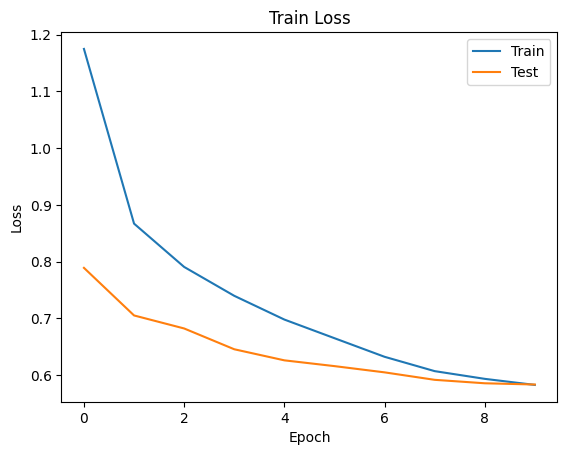

In [15]:
# 새로운 플롯을 생성합니다.
plt.figure()

# 그래프의 제목을 설정합니다.
plt.title('Train Loss')

# x축의 레이블을 설정합니다.
plt.xlabel('Epoch')

# y축의 레이블을 설정합니다.
plt.ylabel('Loss')

# 훈련 손실 데이터를 플롯합니다. 'train_log'에서 'train_loss'를 가져옵니다.
plt.plot(train_log['train_loss'], label='Train')

# 테스트 손실 데이터를 플롯합니다. 'train_log'에서 'test_loss'를 가져옵니다.
plt.plot(train_log['test_loss'], label='Test')

# 범례를 추가하여 각 선의 의미를 설명합니다.
plt.legend()

# 플롯을 화면에 표시합니다.
plt.show()


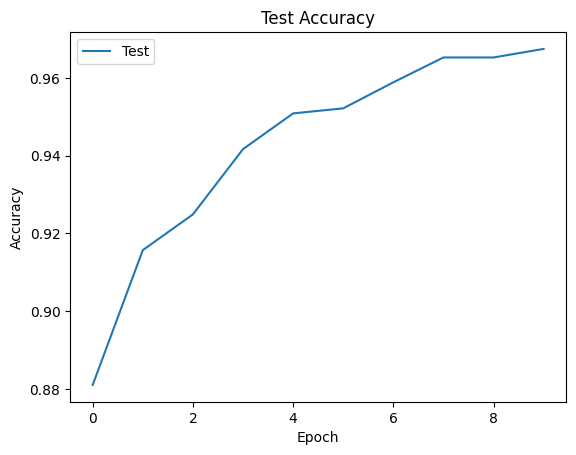

In [16]:
# 새로운 플롯을 생성합니다.
plt.figure()

# 그래프의 제목을 설정합니다.
plt.title('Test Accuracy')

# x축의 레이블을 설정합니다.
plt.xlabel('Epoch')

# y축의 레이블을 설정합니다.
plt.ylabel('Accuracy')

# 테스트 정확도 데이터를 플롯합니다. 'train_log'에서 'acc'를 가져옵니다.
plt.plot(train_log['acc'], label='Test')

# 범례를 추가하여 선의 의미를 설명합니다.
plt.legend()

# 플롯을 화면에 표시합니다.
plt.show()
